In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, concatenate
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Concatenate

# 데이터로드

In [ ]:
df1 = pd.read_csv('21-01-01~22-12-31강진면.csv')

In [ ]:
df2 = pd.read_csv('21-01-01~22-12-31신덕.csv')

In [ ]:
df3 = pd.read_csv('21-01-01~22-12-31곡성.csv')

In [ ]:
w_df = pd.read_csv('가탄교수위.csv')

In [ ]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(w_df.shape)

(17520, 10)
(17520, 10)
(17520, 10)
(17509, 2)


In [ ]:
w_df = w_df.loc[14:]

# 데이터 전처리

In [ ]:
features = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

In [ ]:
test_df1 = df1[features].values
test_df2 = df2[features].values
test_df3 = df3[features].values

In [ ]:
test_wdf = w_df[["수위"]].values

In [ ]:
print(test_df1.shape)
print(test_df2.shape)
print(test_df3.shape)
print(test_wdf.shape)

(17520, 5)
(17520, 5)
(17520, 5)
(17509, 1)


## 정규화

In [ ]:
# 정규화
scaler = MinMaxScaler()

# 상류 하천 데이터 정규화
test_df1_z = scaler.fit_transform(test_df1)
test_df2_z = scaler.fit_transform(test_df2)
test_df3_z = scaler.fit_transform(test_df3)
test_wdf_z = scaler.fit_transform(test_wdf)

In [ ]:
test_df1_z

array([[0.26987061, 0.69288703, 0.16666667, 0.        , 0.76744186],
       [0.23844732, 0.76596932, 0.10784314, 0.        , 0.87209302],
       [0.24214418, 0.83542538, 0.1372549 , 0.        , 0.86046512],
       ...,
       [0.30314233, 0.        , 0.00980392, 0.        , 0.94186047],
       [0.29759704, 0.        , 0.00980392, 0.        , 0.94186047],
       [0.2754159 , 0.19414226, 0.06862745, 0.        , 0.97674419]])

In [ ]:
test_wdf_z

array([[0.05668016],
       [0.05668016],
       [0.05668016],
       ...,
       [0.05668016],
       [0.05668016],
       [0.05668016]])

In [ ]:
print(test_df1_z.shape)
print(test_df2_z.shape)
print(test_df3_z.shape)
print(test_wdf_z.shape)

(17520, 5)
(17520, 5)
(17520, 5)
(17509, 1)


## 차원변환

- 강진면

In [ ]:
time_steps = 12

new_data = []

for i in range(len(test_df1_z) - time_steps + 1):
    batch = test_df1_z[i:i+time_steps]
    new_data.append(batch)

test_df1_re = np.array(new_data)

In [ ]:
test_df1_re

In [ ]:
test_df1_re.shape

(17509, 12, 5)

- 신덕

In [ ]:
new_data = []

for i in range(len(test_df2_z) - time_steps + 1):
    batch = test_df2_z[i:i+time_steps]
    new_data.append(batch)

test_df2_re = np.array(new_data)

In [ ]:
test_df2_re.shape

(17509, 12, 5)

- 곡성

In [ ]:
new_data = []

for i in range(len(test_df3_z) - time_steps + 1):
    batch = test_df3_z[i:i+time_steps]
    new_data.append(batch)

test_df3_re = np.array(new_data)

In [ ]:
test_df3_re.shape

(17509, 12, 5)

In [ ]:
print("NumPy array dtype:", test_df2_re.dtype)

NumPy array dtype: float64


- 수위

In [ ]:
test_wdf_z.shape  # 위에서 변경함

(17509, 1)

# 모델

- CNN_Lstm

In [ ]:
num_top = 3  # 상류 하천의 수
time_steps = 12
# 모델의 입력 레이어 정의
input_layers = []
input_shape = (time_steps, 5)
for i in range(num_top):
    input_layer = Input(shape=input_shape, name=f'aws_{i+1}')
    input_layers.append(input_layer)

# CNN 레이어 정의
cnn_layers = []
for i in range(num_top):
    cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layers[i])
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    cnn_layers.append(cnn_layer)

concatenated_outputs = Concatenate()(cnn_layers)
lstm_input = tf.keras.layers.Reshape((num_top, -1))(concatenated_outputs)  # LSTM에 입력하기 위해 차원 재구성


lstm_layer = LSTM(32, activation='relu')(lstm_input)

output_layer = Dense(1, activation='linear', name='water')(lstm_layer)

In [ ]:
# 모델 컴파일
model = Model(inputs=input_layers, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 aws_1 (InputLayer)             [(None, 12, 5)]      0           []                               
                                                                                                  
 aws_2 (InputLayer)             [(None, 12, 5)]      0           []                               
                                                                                                  
 aws_3 (InputLayer)             [(None, 12, 5)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 10, 64)       1024        ['aws_1[0][0]']                  
                                                                                              

# 학습

In [ ]:
model.fit([test_df1_re, test_df2_re, test_df3_re], test_wdf_z, epochs=100, batch_size=32)

Epoch 1/100
548/548 [==============================] - 8s 9ms/step - loss: 0.0037 - mae: 0.0396
Epoch 2/100
548/548 [==============================] - 4s 7ms/step - loss: 0.0027 - mae: 0.0351
Epoch 3/100
548/548 [==============================] - 4s 7ms/step - loss: 0.0025 - mae: 0.0341
Epoch 4/100
548/548 [==============================] - 5s 9ms/step - loss: 0.0024 - mae: 0.0334
Epoch 5/100
548/548 [==============================] - 4s 7ms/step - loss: 0.0023 - mae: 0.0327
Epoch 6/100
548/548 [==============================] - 4s 7ms/step - loss: 0.0022 - mae: 0.0322
Epoch 7/100
548/548 [==============================] - 5s 9ms/step - loss: 0.0021 - mae: 0.0321
Epoch 8/100
548/548 [==============================] - 4s 6ms/step - loss: 0.0020 - mae: 0.0313
Epoch 9/100
548/548 [==============================] - 4s 6ms/step - loss: 0.0020 - mae: 0.0309
Epoch 10/100
548/548 [==============================] - 5s 9ms/step - loss: 0.0019 - mae: 0.0306
Epoch 11/100
548/548 [=================

# 결과

In [ ]:
predictions = model.predict([test_df1_re, test_df2_re, test_df3_re])

548/548 [==============================] - 3s 4ms/step


In [ ]:
predictions_scale = scaler.inverse_transform(predictions)

In [ ]:
predictions_scale.shape

(17509, 1)

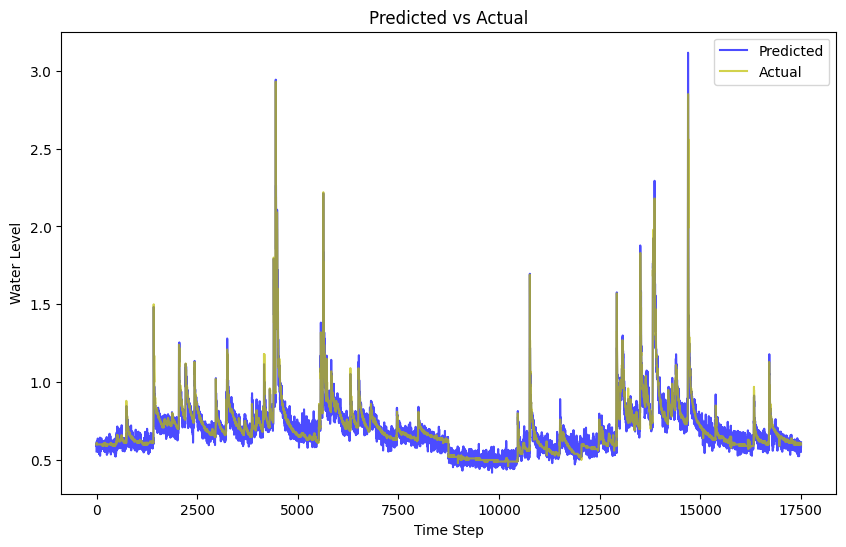

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(predictions_scale, label='Predicted', color = 'b', alpha=0.7)
plt.plot(test_wdf, label='Actual', color = 'y', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Water Level')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()  # 그래프 왤케 튀는거같지...

In [ ]:
predictions_scale[:10]

array([[0.5552641 ],
       [0.59581614],
       [0.61227906],
       [0.5764028 ],
       [0.6114846 ],
       [0.5859016 ],
       [0.5992349 ],
       [0.60378826],
       [0.58772796],
       [0.6209805 ]], dtype=float32)

- 모델저장

In [ ]:
model.save("model_test(12)_cnn.h5")

In [ ]:
from pickle import dump

dump(scaler, open('./12_cnn_scaler.pkl', 'wb'))

# 모델 테스트

- 걍다시 ㄱ

In [ ]:
t1 = pd.read_csv('11111.csv')

In [ ]:
t2 = pd.read_csv('22222.csv')

In [ ]:
t3 = pd.read_csv('33333.csv')

In [ ]:
tw = pd.read_csv('test수위.csv')

In [ ]:
test_w = tw[["수위"]].values

In [16]:
from keras.models import load_model

model_filename = 'model_test(12)_cnn.h5'

loaded_model = load_model(model_filename)

In [17]:
from pickle import load

load_minmax_scaler = load(open('12_cnn_scaler.pkl', 'rb'))

## 데이터 전처리

In [ ]:
features = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

In [ ]:
test_t1 = t1[features].values
test_t2 = t2[features].values
test_t3 = t3[features].values

### 정규화

In [ ]:
# 정규화
scaler = MinMaxScaler()

# 상류 하천 데이터 정규화
test_df1_z = scaler.fit_transform(test_t1)
test_df2_z = scaler.fit_transform(test_t2)
test_df3_z = scaler.fit_transform(test_t3)

In [ ]:
time_steps = 12

new_data = []

for i in range(len(test_df1_z) - time_steps + 1):
    batch = test_df1_z[i:i+time_steps]
    new_data.append(batch)

test_df1_re = np.array(new_data)

In [ ]:
test_df1_re.shape

(61, 12, 5)

In [ ]:
time_steps = 12
features = 10

new_data = []

for i in range(len(test_df2_z) - time_steps + 1):
    batch = test_df2_z[i:i+time_steps]
    new_data.append(batch)

test_df2_re = np.array(new_data)

In [ ]:
time_steps = 12
features = 10

new_data = []

for i in range(len(test_df3_z) - time_steps + 1):
    batch = test_df3_z[i:i+time_steps]
    new_data.append(batch)

test_df3_re = np.array(new_data)

### 결과

In [ ]:
predictions = loaded_model.predict([test_df1_re, test_df2_re, test_df3_re])

2/2 [==============================] - 0s 6ms/step


In [ ]:
predictions

In [ ]:
predictions_scaler = load_minmax_scaler.inverse_transform(predictions)

In [ ]:
predictions_scaler

array([[0.4631998 ],
       [0.490789  ],
       [0.5197516 ],
       [0.5396739 ],
       [0.48015493],
       [0.592755  ],
       [0.62454295],
       [0.57256794],
       [0.6475049 ],
       [0.62994426],
       [0.6655306 ],
       [0.6290023 ],
       [0.58000463],
       [0.60104513],
       [0.6157942 ],
       [0.653718  ],
       [0.65846455],
       [0.638931  ],
       [0.582707  ],
       [0.5963017 ],
       [0.5420569 ],
       [0.57738286],
       [0.6095278 ],
       [0.6085846 ],
       [0.6125599 ],
       [0.5232726 ],
       [0.58738625],
       [0.6937245 ],
       [0.74506646],
       [0.70742846],
       [0.67856187],
       [0.69193923],
       [0.6890549 ],
       [0.75553465],
       [0.75965476],
       [0.75417763],
       [0.77448386],
       [0.4227835 ],
       [0.3550676 ],
       [0.550146  ],
       [0.7420023 ],
       [0.75973284],
       [0.82736176],
       [0.74456704],
       [0.70776176],
       [0.6548042 ],
       [0.58277756],
       [0.450

In [ ]:
predictions_scaler.shape

(61, 1)

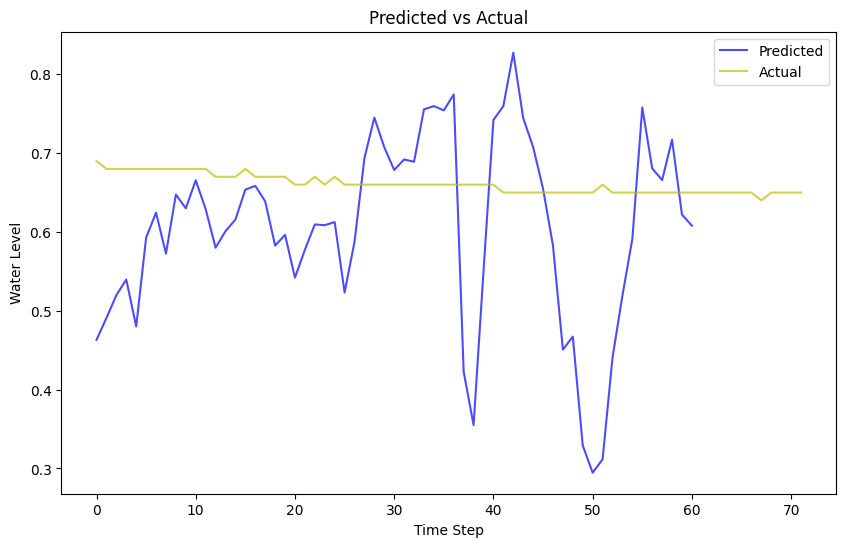

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(predictions_scaler, label='Predicted', color = 'b', alpha=0.7)
plt.plot(test_w, label='Actual', color = 'y', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Water Level')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

## 3시간 테스트
-> 27개의데이터

In [3]:
t1 = pd.read_csv('test12-1.csv')

In [4]:
t2 = pd.read_csv('test12-2.csv')

In [5]:
t3 = pd.read_csv('test12-3.csv')

In [6]:
features = ['기온(°C)', '풍향(deg)', '풍속(m/s)', '강수량(mm)', '습도(%)']

In [ ]:
t1

In [8]:
test_t1 = t1[features].values
test_t2 = t2[features].values
test_t3 = t3[features].values

In [9]:
# 정규화
scaler = MinMaxScaler()

# 상류 하천 데이터 정규화
test_df1_z = scaler.fit_transform(test_t1)
test_df2_z = scaler.fit_transform(test_t2)
test_df3_z = scaler.fit_transform(test_t3)

In [10]:
time_steps = 12

new_data = []

for i in range(len(test_df1_z) - time_steps + 1):
    batch = test_df1_z[i:i+time_steps]
    new_data.append(batch)

test_df1_re = np.array(new_data)

In [11]:
time_steps = 12

new_data = []

for i in range(len(test_df2_z) - time_steps + 1):
    batch = test_df2_z[i:i+time_steps]
    new_data.append(batch)

test_df2_re = np.array(new_data)

In [12]:
time_steps = 12

new_data = []

for i in range(len(test_df3_z) - time_steps + 1):
    batch = test_df3_z[i:i+time_steps]
    new_data.append(batch)

test_df3_re = np.array(new_data)

In [13]:
test_df3_re.shape

(3, 12, 5)

In [18]:
predictions_t3 = loaded_model.predict([test_df1_re, test_df2_re, test_df3_re])

1/1 [==============================] - 0s 464ms/step


In [19]:
predictions_scaler_3 = load_minmax_scaler.inverse_transform(predictions_t3)

In [20]:
predictions_scaler_3

array([[0.5191387 ],
       [0.3649495 ],
       [0.39134344]], dtype=float32)

In [21]:
tw1 = pd.read_csv('test수위12-1.csv')

In [22]:
test_w = tw1[["수위"]].values

In [23]:
test_w

array([[0.69],
       [0.68],
       [0.69]])

In [24]:
# RMSE
rmse = np.sqrt(((predictions_scaler_3 - test_w) ** 2).mean())

# MAE
mae = np.abs(predictions_scaler_3 - test_w).mean()

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.2693486866483694
MAE: 0.2615227890014648


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(predictions_scaler_3, label='Predicted', color = 'b', alpha=0.7)
plt.plot(test_w, label='Actual', color = 'y', alpha=0.7)

plt.xlabel('Time Step')
plt.ylabel('Water Level')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

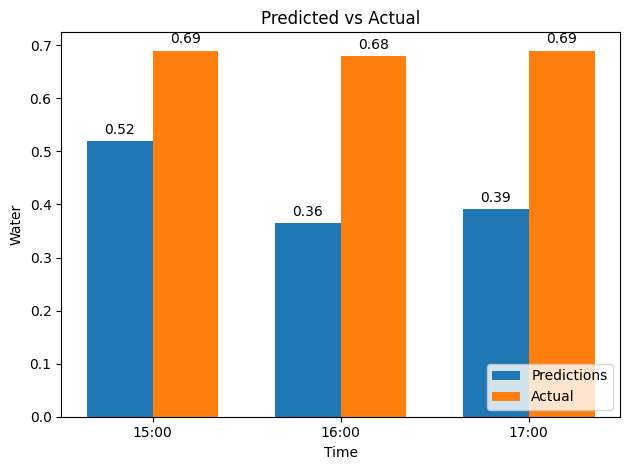

In [25]:
# 데이터 포인트 레이블
data_labels = ['15:00', '16:00', '17:00']

# 그래프 데이터
x = np.arange(len(data_labels))
width = 0.35

# 예측값과 실제값 막대 그래프 생성
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, predictions_scaler_3.flatten(), width, label='Predictions')
rects2 = ax.bar(x + width/2, test_w.flatten(), width, label='Actual')

ax.set_xlabel('Time')
ax.set_ylabel('Water')
ax.set_title('Predicted vs Actual')
ax.set_xticks(x)
ax.set_xticklabels(data_labels)
ax.legend()

ax.legend(loc='lower right')

# 막대 위에 값 표시
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()